# CMIP6 data

This notebook shows how to access CMIP6 data from the cloud

## Import modules and libraries

*First, let's make sure the Python env is correct to run this notebook*:

In [1]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2025/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"), 
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    ds2tools = check_up_env(with_tuto=True)

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/tmp4qnwxxlg/utils.py:69: UserWarning: 
Running on your own environment
Make sure to have all necessary packages installed
See:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml
  warnings.warn("\nRunning on your own environment\nMake sure to have all necessary packages installed\nSee:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml")


In [2]:
import sys
import gcsfs
import xarray as xr
import intake
import zarr
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
create_map = ds2tools.create_map

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# 
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

/Users/gmaze/miniconda3/envs/ds2-coiled-2025-binder/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Read the full CMIP6 catalog

In [3]:
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_full.sample(10)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
237301,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r2i1p1f1,Amon,hur,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
29190,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Efx,clayfrac,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
217657,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp245,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,NaN,20190708
372602,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r32i1p1f1,Omon,sos,gr,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1995.0,20191016
143519,ScenarioMIP,CCCma,CanESM5,ssp119,r6i1p2f1,SImon,simass,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
409146,PAMIP,NCAR,CESM2,piSST-pdSIC,r75i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM2/piSST-pdSIC/...,NaN,20200121
87768,CMIP,CCCma,CanESM5-CanOE,piControl,r1i1p2f1,Omon,wmo,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...,NaN,20190429
106244,CMIP,CCCma,CanESM5,historical,r15i1p2f1,Amon,hfls,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
149403,ScenarioMIP,CCCma,CanESM5,ssp126,r5i1p1f1,Omon,zostoga,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
93000,ScenarioMIP,CCCma,CanESM5,ssp585,r9i1p1f1,Omon,dissicnatos,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429


### Make a subset of it

In [4]:
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'historical'")
# df = df_full.query('institution_id == "CNRM-CERFACS" & member_id=="r1i1p1f2" & source_id=="CNRM-CM6-1"')

# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'abrupt-4xCO2'")

# df = df.query("source_id=='CNRM-CM6-1-HR' & variable_id=='thetao'") # Horizontal resolution up to 1/4 deg
# df = df.query("source_id=='CNRM-ESM2-1' & variable_id=='thetao'") # Horizontal resolution up to 1deg
df = df.query("source_id=='CNRM-ESM2-1' & (variable_id=='thetao' | variable_id=='so')") # Horizontal resolution up to 1deg

# df = df.sort_values('version')
df = df.sort_values('member_id')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
406634,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r10i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200117
406642,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r10i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200117
430447,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r11i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200408
44083,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
44013,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
51505,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r2i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51514,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r2i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51428,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r3i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
50556,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r3i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51214,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r4i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125


## Read some data (1 row of the catalog)

In [5]:
def open_cmip6(df_row):
    # get the path to zarr store
    zstore = df.zstore.values[-1]

    # open it using xarray and zarr
    return xr.open_dataset(zstore, consolidated=True, engine='zarr', 
                     backend_kwargs={"storage_options": { "token": 'anon',  'access':'read_only'}})

ds = open_cmip6(df.iloc[0])
ds

<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, lev: 75, axis_nbounds: 2,
                  time: 1980)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 ...
    bounds_lon   (y, x, nvertex) float64 ...
    lat          (y, x) float64 ...
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, axis_nbounds) float64 ...
    lon          (y, x) float64 ...
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] ...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    thetao       (time, lev, y, x) float32 ...
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r9i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/8e969929-c070-414d-9eca-f4c99b7be8b7...
    variable_id:            thetao
    variant_label:          r9i1p1f2
    xios_commit:            1442-shuffle
    netcdf_tracking_ids:    hdl:21.14100/8e969929-c070-414d-9eca-f4c99b7be8b7...
    version_id:             v20200117

### Play with it

In [6]:
# Compute size of the full df selection:
total_size = 0 # Gb
for index, row in df.iterrows():
    ds = open_cmip6(row)
    total_size += ds.nbytes/1e9
print("Size of the selection of datasets:", total_size, "Gb")    

Size of the selection of datasets: 1327.7627067600004 Gb


In [7]:
sst = ds['thetao'].sel(lev=0, method='nearest')
sst

<xarray.DataArray 'thetao' (time: 1980, y: 294, x: 362)>
[210727440 values with dtype=float32]
Coordinates:
    lat      (y, x) float64 ...
    lev      float64 0.5058
    lon      (y, x) float64 ...
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areacello volume: volcello
    cell_methods:        area: mean where sea time: mean
    description:         Diagnostic should be contributed even for models usi...
    history:             none
    interval_operation:  1800 s
    interval_write:      1 month
    long_name:           Sea Water Potential Temperature
    online_operation:    average
    standard_name:       sea_water_potential_temperature
    units:               degC

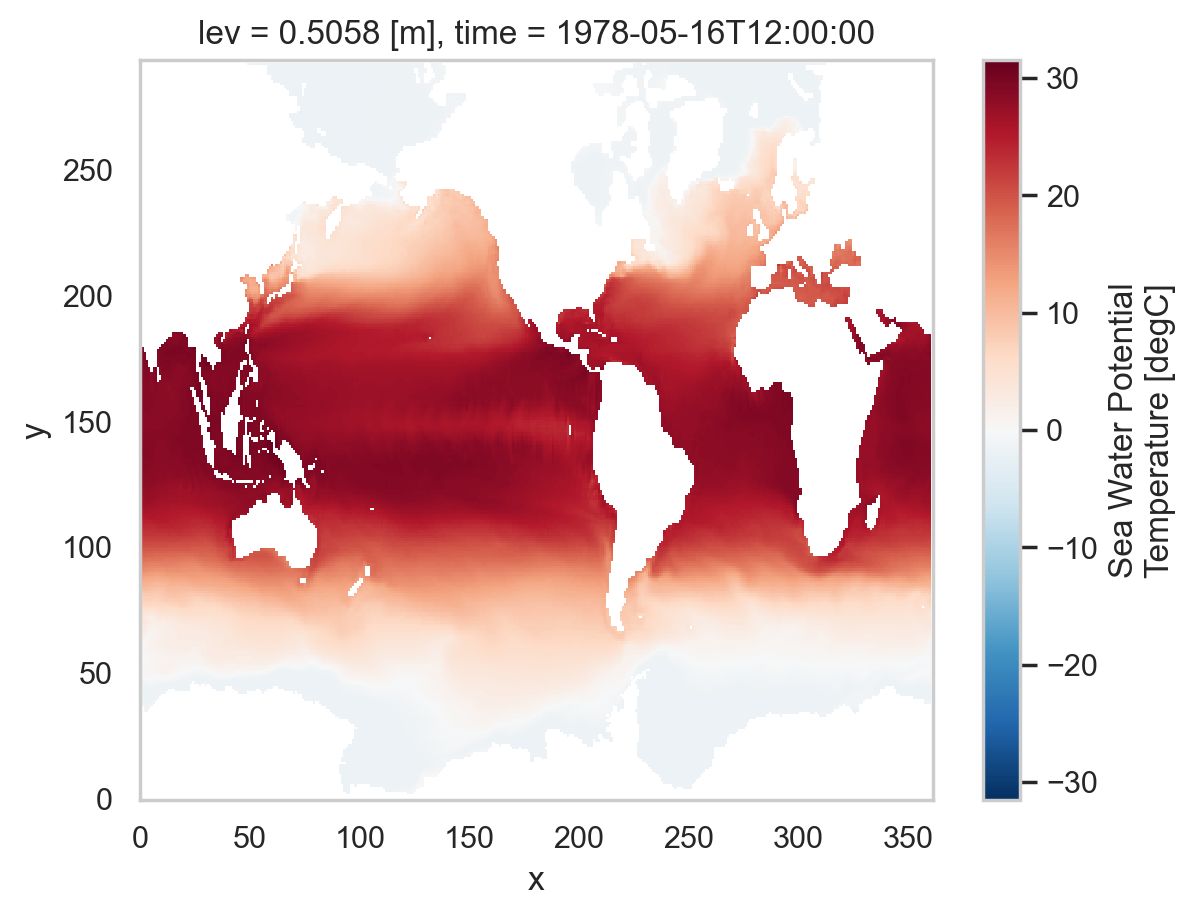

In [8]:
sst.sel(time='1978-05-28T12:00:00', method='nearest').plot()

In [ ]:
sst.where(sst['lat']>=0).where(sst['lon']>=360-275).sel(time='1978-05-28T12:00:00', method='nearest').plot(xlim=[0, 120], ylim=[140, 270])

### Horizontal resolution of the grid

In [ ]:
ds['lat'].isel(x=0).diff('y').plot()

In [ ]:
ds['lon'].isel(y=0).diff('x').plot()

## Connect to a cluster for large computation

In [ ]:
import coiled
from dask.distributed import Client
# Connect to one of the existing class cluster: 
# cluster = coiled.Cluster(name="ds2-highmem-binder", workspace="class-2025")
cluster = coiled.Cluster(name="ds2-highcpu-binder", workspace="class-2025")
client = cluster.get_client()

## Compute climatology

In [ ]:
ds = open_cmip6(df.iloc[0])
print("Size of this dataset:", ds.nbytes/1e9,"Gb")

In [ ]:
%%time
t = ds['thetao'].sel(lev=700, method='nearest')
# t = t.where(t['lat']>=30).where(t['lon']>=360-275)
# t = t.where(t['time']>=pd.to_datetime('2100-01-01'))
# t
tm = t.mean(dim='time')
tm

In [ ]:
%%time

# This should take about 9mins on ds2-highmem-binder and 4mins on ds2-highcpu-binder:
tm = tm.compute().persist()
tm

In [ ]:
fig, proj, ax = create_map()
tm.plot(transform=proj, x='lon', y='lat', ax=ax, 
        vmin=-2, vmax=15, levels=18, 
        cmap=mpl.colormaps.get_cmap('bwr'))
# ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAND, facecolor=[0.7]*3, zorder=100)
ax.set_title("Ocean temperature climatology at z=%0.1f m" % tm['lev'].data)

## Checkout a High resolution simulation

In [ ]:
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'historical'")
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'piControl'")
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS'")
# df = df_full.query('institution_id == "CNRM-CERFACS" & member_id=="r1i1p1f2" & source_id=="CNRM-CM6-1"')

# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'abrupt-4xCO2'")

# df = df.query("source_id=='CNRM-CM6-1-HR'") # Horizontal resolution up to 1/4 deg
df = df.query("source_id=='CNRM-CM6-1-HR' & variable_id=='thetao'") # Horizontal resolution up to 1/4 deg
# df = df.query("source_id=='CNRM-ESM2-1' & variable_id=='thetao'") # Horizontal resolution up to 1deg
# df = df.query("source_id=='CNRM-ESM2-1' & (variable_id=='thetao' | variable_id=='so')") # Horizontal resolution up to 1deg

# df = df.sort_values('version')
df = df.sort_values('member_id')
df

In [ ]:
this_df = df[df['variable_id'] == 'thetao'].iloc[0]
# this_df = df[df['experiment_id'] == 'piControl'].iloc[0]
ds = open_cmip6(this_df)
ds

In [ ]:
%%time
t = ds['thetao'].sel(lev=700, method='nearest')
tm = t.mean(dim='time')
tm = tm.compute().persist()
tm

In [ ]:
fig, proj, ax = create_map()
# fig, proj, ax = create_map(extent=[-90, 0, 0, 80])
tm.plot(transform=proj, x='lon', y='lat', ax=ax, 
        vmin=-2, vmax=15, levels=18, 
        cmap=mpl.colormaps.get_cmap('bwr'))
# ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAND, facecolor=[0.7]*3, zorder=100)
ax.set_title("Ocean temperature climatology at z=%0.1f m" % tm['lev'].data)